# TP2 - Spatial Filtering
**IMPRO - Master CORO SIP- Ecole Centrale Nantes**

Ecole Centrale Nantes

Diana Mateus

Participants: (FILL IN YOUR NAMES AND LASTNAMES)

# GOAL

In this lab we will practice the general principles of linear spatial filtering for 2D images:
- based on the convolution operation
- and applied with different filters to solve different tasks (denoising, highboost sharpening, border extraction)

Then, if we have time, we will break some of the linear filtering assumptions:
- to find patterns in an image (Waldo/Charlie) with correlation,
- to filter preserving borders,
- to find corners in an image


# 0. Preparation

* Define the path to the images only once. Then, use the given path for the images

* Handling several large images can create large memory demands. In order to avoid large size files that slow processing, you can:
  - reuse the image variable names
  - clear large variables with the command
   ```reset_selective name_variable```
  - If required resize the images while debugging (e.g. to 100x100)
  - Before submiting your jupyter notebook empty the outputs first: go to the Kernel menu, restart and clear output.

  - If you get some warnings "IOPub data rate exceeded" launch your notebook with

  ```jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000```



### 0.1 Importing the required modules


In [2]:
import skimage.io as io
import matplotlib.pyplot as plt
import numpy as np
import os
import math
from skimage.restoration import denoise_bilateral
from skimage.transform import resize, rescale
from scipy import ndimage
from scipy import signal


### 0.2 Define the main image folder
Make sure the subsequent parts of this notebook refer to this definition IMDIR. **When evaluating your notebook I should only need to change the path here** to run the entire notebook and find all the images

In [3]:
IMDIR = "./images"


In [4]:
IMDIR


'./images'

In [5]:
#If using Colab
#from google.colab import drive
#drive.mount('/content/drive')
#IMDIR = "/content/drive/MyDrive/Colab Notebooks/2022-2023 Image Processing/02-spatial-filtering /images/"

### 0.3 Read and display the images
Check that you can read and display all the provided images. **Do not include this cell**, neither the code nor its ouput in the final report.

grass.jpg
rubiks_cube.png
painted-house-landroid-2.jpg
painted-house-landroid-3.jpg
painted-house-landroid-1.jpg
painted-house-landroid-4.jpg
tigre-paris-1.jpg
tigre-paris-2.jpg
tigre-paris-3.png
pixel-pancho-2.jpg
lego-cropped.jpg
pixel-pancho-1.jpg
marche.jpg
charlie-template.jpeg
marche-crop.png
zebra_speckle_0.png
zebra_speckle_1.png
zebra_speckle_2.png
zebra_gaussian_2.png
zebra_gaussian_0.png
zebra_gaussian_1.png
zebra_saltAndPepper.png
ref.jpg
tajMahal_speckle_1.png
tajMahal_speckle_0.png
einstein_gaussian_2.png
ref.png
ascentB.png


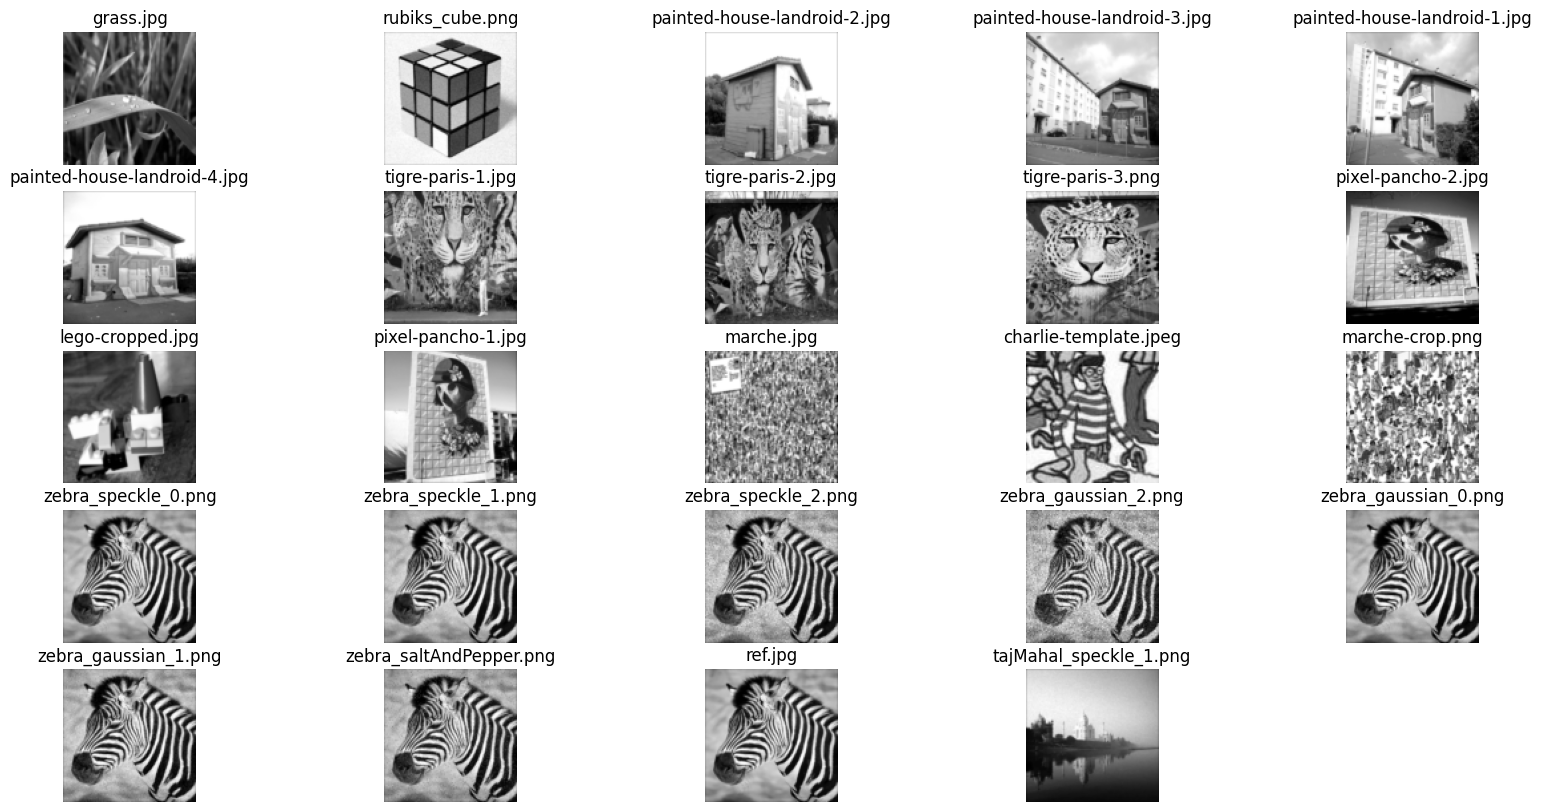

In [6]:
width=20
height=10
plt.rcParams['figure.figsize'] = [width, height]
fig=plt.figure()

im_counter = 1
for root, dirnames, filenames in os.walk(IMDIR):
    #print(dirnames)
    for filename in filenames:
        f = os.path.join(root, filename)

        #filter only image files with the following format
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):

            # print the paths to current filename if nothing is being found
            print(filename)

            # read the image
            im = io.imread(f,as_gray=True)
            im = resize(im,(100,100),mode='constant')

            # display it
            if im_counter >= 25:
                break;

            plt.subplot(5,5,im_counter)
            plt.imshow(im, cmap='gray')
            plt.title(filename)
            plt.axis('off')
            im_counter +=1



plt.show()




# 1 Linear spatial filtering with convolution




## 1.1. Mean Kernel Example
The following ``meanKernel'' function creates a smoothing kernel, which can be used with scipy's ``` ndimage.convolve(im,kernel) ```
convolution function to blur an image.

Run the following cells to display different versions of the kernel and the application of a mean_kernel on an image.


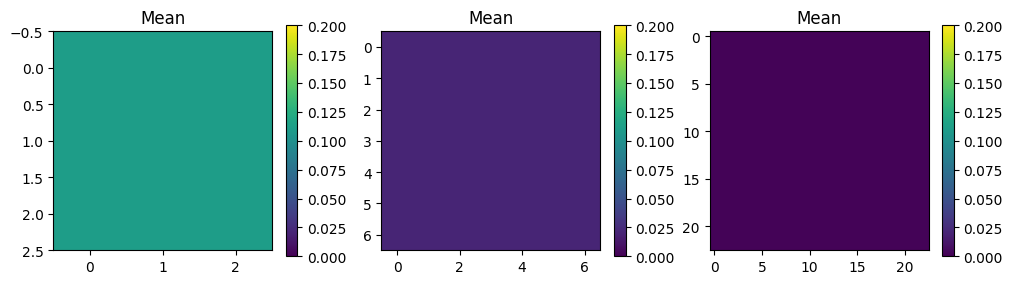

In [7]:
def meanKernel(hs):
    #hs defines the size of the kernel
    #hs is the integer half size of the kernel
    #creates an square filter with each side of length 2*hs+1
    kernel = np.zeros((hs*2+1,hs*2+1))
    kernel += 1/(hs*2+1)**2
    return kernel

#Display properties
width=12
height=3
plt.rcParams['figure.figsize'] = [width, height]

#creating and showing three mean kernels of different sizes
k = 1
for hs in [1,3,11]:
    plt.subplot(1,3,k)
    kernel = meanKernel(hs)
    plt.imshow(kernel, vmin=0, vmax=0.2)
    plt.title('Mean')
    plt.colorbar()
    k+=1
plt.show()


Text(0.5, 1.0, 'Mean scipy conv')

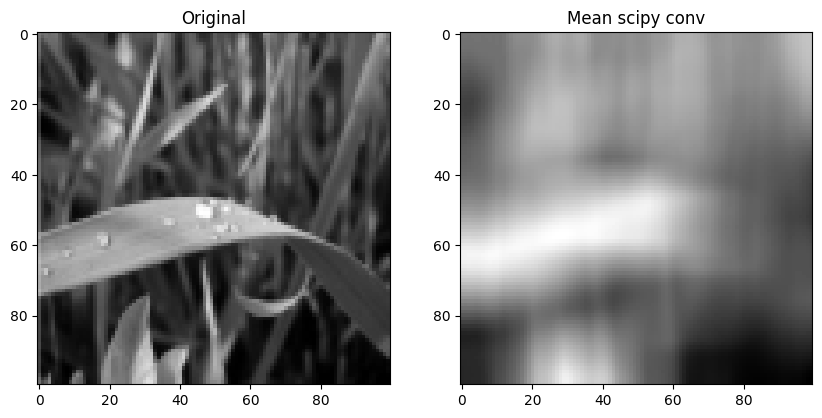

In [8]:
f = os.path.join(IMDIR, "grass.jpg")

#Display properties
width=10
height=5

#Filter parameters
hs = 11
sigma = 2

# Read and preprocess image
im = io.imread(f, as_gray=True)
# print(im.shape)
im = im.astype(float)
im = resize(im,(100,100))

# Define filter and convolve
kernel = meanKernel(hs)
# print(kernel.shape)
im_filtered_scipy = ndimage.convolve(im,kernel)

# Display the original image
fig=plt.figure(figsize=(width, height))
plt.subplot(1,2,1)
plt.imshow(im, cmap = 'gray')
plt.title('Original')

# Display the filtered image
plt.subplot(1,2,2)
plt.imshow(im_filtered_scipy, cmap = 'gray')
plt.title('Mean scipy conv')


## 1.2. Gaussian Kernel
Following the above example, create, display and apply several (at least 3) Gaussian kernels with varying window size and standard deviation.

**Question: ** what is the sum of the kernel elements in each case?, why is this necessary?

```Hints```:
- use the 'None' or 'Nearest' interpolation options of imshow to display the kernel images

In [9]:
#both versions work, pick the one you are more confortable with

def gaussianKernel(hs,sigma, normalize=True): #half window size and Gaussian sigma
    # creating an empty kernel
    kernel = np.zeros((hs*2+1,hs*2+1))
    ax = np.arange(-hs, hs+1)
    
    # print("ax is ",ax)

    # filling the kernel elements
    xx, yy = np.meshgrid(ax, ax)

    ### FILL BEGIN
    s=1/(2*(np.pi)*sigma**2)
    kernel = s*np.exp(-(xx**2+yy**2)/(2*sigma**2) ) #FILL IN
    ### FILL END

    # normalize and return
    if normalize:
        kernel = kernel / np.sum(kernel)

    return kernel

#def gaussianLambdaKernel(size,sigma, normalize=True): #full window size and Gaussian sigma

    ### FILL BEGIN
    # kernel = np.fromfunction(lambda x, y: (1/(2*math.pi*sigma**2))*math.e ** ((x-(size-1)/2)**2+(y-(size-1)/2)**2))/(2*sigma**2), (size, size))
    ### FILL END

    # if normalize:
    #     kernel = kernel / np.sum(kernel)

    # return kernel



In [10]:
g1=gaussianKernel(3,0.5)
g1
print(np.sum(g1))

0.9999999999999997


In [11]:
g2=gaussianKernel(11,0.5)
g2
print(np.sum(g2))

0.9999999999999999


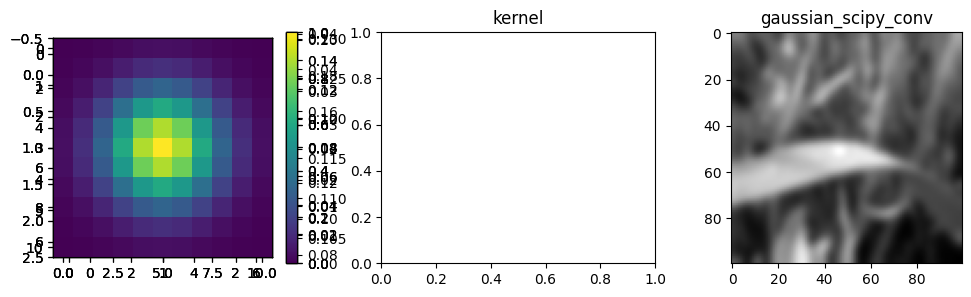

In [12]:
filter_sizes=[1,3,5]
sigma_values=[0.1,1,2]
for i in filter_sizes:
    for j in sigma_values:
        kernel=gaussianKernel(i,j)
        plt.subplot(1,3,1)
        plt.imshow(kernel)
        plt.subplot(1,3,2)
        plt.colorbar()
        plt.title('kernel') 
        im_filtered_scipy = ndimage.convolve(im,kernel)
        plt.subplot(1,3,3)
        plt.imshow(im_filtered_scipy, cmap = 'gray')
        plt.title('gaussian_scipy_conv')  
            
               
               

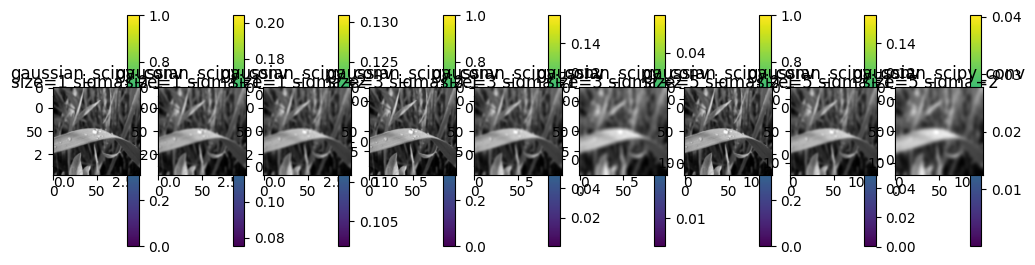

In [13]:
filter_sizes=[1,3,5]
sigma_values=[0.1,1,2]
k=1
l=len(filter_sizes)*len(sigma_values)
for i in filter_sizes:
    for j in sigma_values:
        kernel=gaussianKernel(i,j)
        plt.subplot(1,l,k)
        plt.imshow(kernel)
        plt.subplot(1,l,k)
        plt.colorbar()
        plt.title(f"size={i} sigma={j}") 
        im_filtered_scipy = ndimage.convolve(im,kernel)
        plt.subplot(1,l,k)
        plt.imshow(im_filtered_scipy, cmap = 'gray')
        plt.title('gaussian_scipy_conv') 
        k+=1
        
        # plt.imshow(kernel, cmap = 'gray')
        # plt.title('kernel') 
# for i in filter_sizes:
#     for j in sigma_values:
#         im_filtered_scipy = ndimage.convolve(im,kernel)
#         plt.subplot(1,s,k)
#         plt.imshow(im_filtered_scipy, cmap = 'gray')
#         plt.title('gaussian_scipy_conv') 
#         k+=1 
            

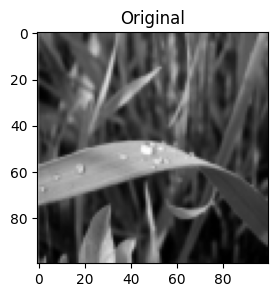

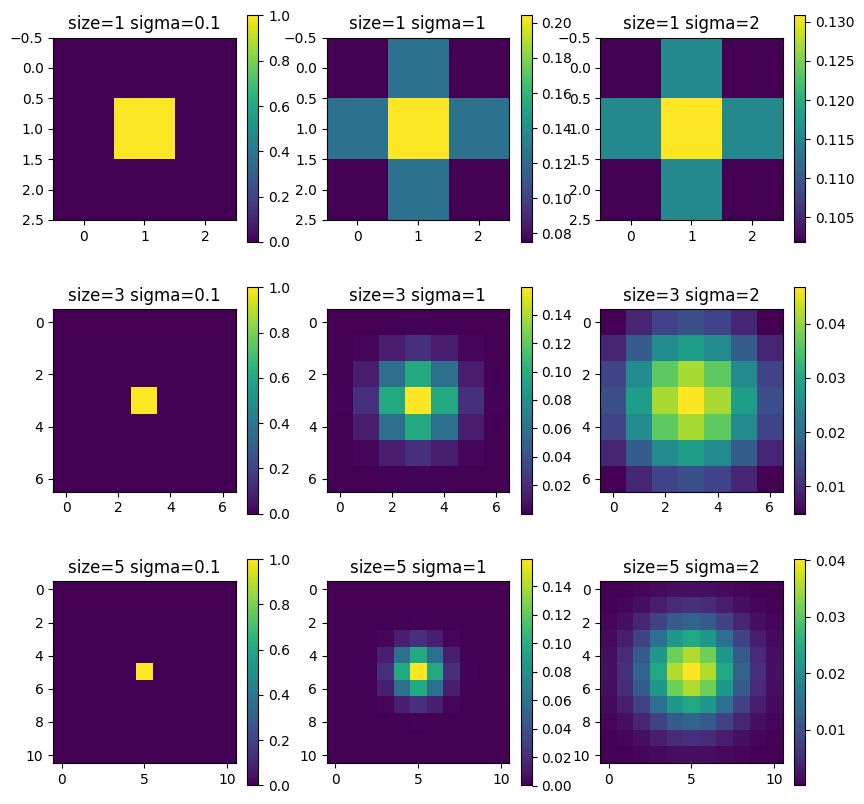

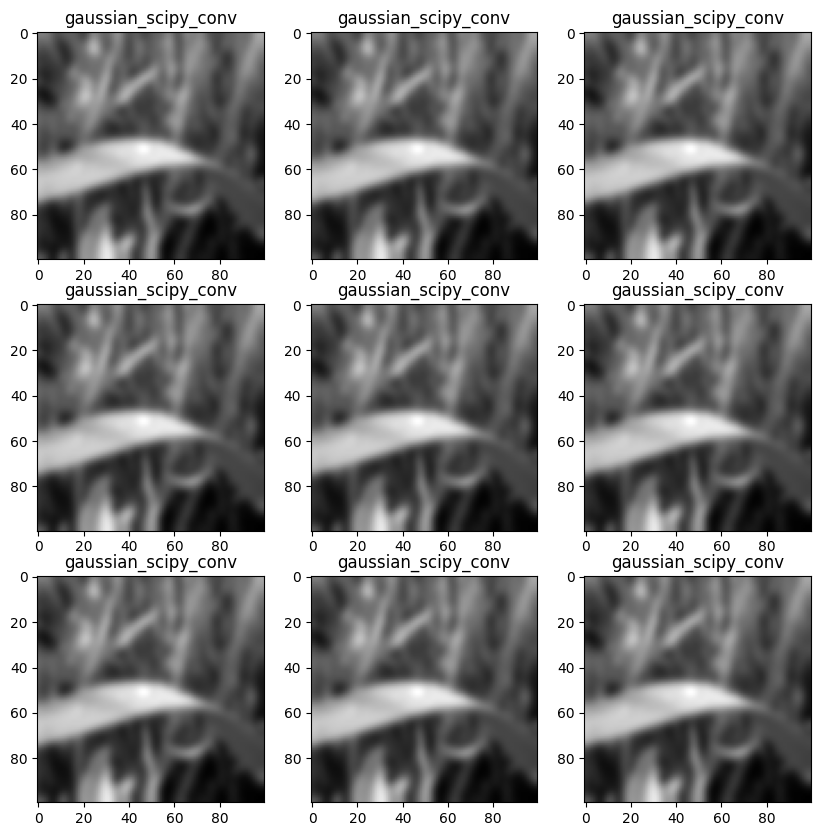

In [14]:
f = os.path.join(IMDIR, "grass.jpg")

#Display size
width=10
height=10

# Read and preprocess image
im = io.imread(f, as_gray=True)
im = im.astype(float)
im = resize(im,(100,100))

# Display the original image
fig=plt.figure(figsize=(3, 3))
plt.imshow(im, cmap = 'gray')
plt.title('Original')

# Define filter parameters
filter_sizes=[1,3,5]
sigma_values=[0.1,1,2]

# Display filters as images
fig=plt.figure(figsize=(width, height))

filter_sizes=[1,3,5]
sigma_values=[0.1,1,2]
k=1
l=2*len(filter_sizes)*len(sigma_values)
for i in filter_sizes:
    for j in sigma_values:
        kernel=gaussianKernel(i,j)
        plt.subplot(3,3,k)
        plt.imshow(kernel)
        plt.subplot(3,3,k)
        plt.colorbar()
        plt.title(f"size={i} sigma={j}")  
        k+=1


# #FILL IN

# plt.show()

# # Convolve the image with the filter and display the filtered image
num_im=1
fig=plt.figure(figsize=(width, height))
for i in filter_sizes:
    for j in sigma_values:
        im_filtered_scipy = ndimage.convolve(im,kernel)
        plt.subplot(3,3,num_im)
        plt.imshow(im_filtered_scipy, cmap = 'gray')
        plt.title('gaussian_scipy_conv') 
        num_im+=1
# #FILL IN

# plt.show()







## 1.3 Filtering with your own Convolution
**a)** Repeat the smoothing above with your own implementation of the ```convolution``` function. The function should receive as input an image and a filter kernel (matrix of weights) and return the filtered image. Compare your results with those from the scikit in-built function.

**b)** Apply a Gaussian filter of kernel size 7x7 (hs=3) and sigma 2 display side by side the results of your convolution vs. those of the in-built function to check your implementation is correct. Clearly state on the title of the image which version of the convolution function is being used.

**c)** **Write down your findings**, notably the reasons for any possible difference with the in-built implementation.

**d)** Why and how can the convolution can be written as a matrix multiplication? why is it interesting?
```Hint```:  see http://cs231n.github.io/convolutional-networks/

In [15]:
def myConvolution(imsource,kernel):

    # Find image and kernel sizes
    im_shape = imsource.shape
    imh,imw = im_shape[0], im_shape[1]
    kh,kw = kernel.shape
    delta_h=int((kh-1)/2)
    delta_w=int((kw-1)/2)

    # Image padding
    imPadded = np.zeros((imh+2*delta_h,imw+2*delta_w))
    imPadded[delta_h:imh+delta_h,delta_w:imw+delta_w]=imsource

    # Create an empty image to store the result
    imDest = np.zeros((imh,imw))

    #BEGIN FILL IN
    for i in range(imh):
        for j in range(imw):
            patch=imPadded[i:(i+kh),j:(j+kw)]
            # imDest[i,j]=np.multiply(patch,kernel[::-1,::-1]).sum()
            imDest[i,j]=np.sum(patch*kernel)

    #END FILL IN
    return imDest


Text(0.5, 1.0, 'my_img-scipy_conv_img')

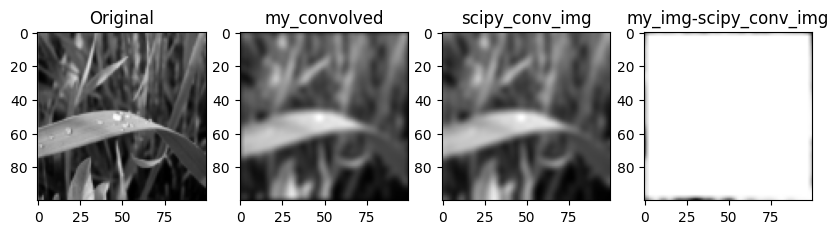

In [ ]:
f = os.path.join(IMDIR, "grass.jpg")

#Display properties
width=10
height=10

# Read and preprocess image
im = io.imread(f, as_gray=True)
im = im.astype(float)
im = resize(im,(100,100))

# Display the original image
fig=plt.figure(figsize=(width, height))
plt.subplot(1,4,1)
plt.imshow(im, cmap = 'gray')
plt.title('Original')

# Define filter parameters
hs=3
sigma=2
kernel = gaussianKernel(hs,sigma)

# Convolve and display the filtered image
my_img=myConvolution(im,kernel)
plt.subplot(1,4,2)
plt.imshow(my_img, cmap = 'gray')
plt.title('my_convolved')

scipy_conv_img=ndimage.convolve(im,kernel)
plt.subplot(1,4,3)
plt.imshow(scipy_conv_img, cmap = 'gray')
plt.title('scipy_conv_img')

diff_img=np.subtract(my_img,scipy_conv_img)
plt.subplot(1,4,4)
plt.imshow(diff_img, cmap = 'gray')
plt.title('my_img-scipy_conv_img')

## 1.4 Derivative filters

Define the required kernel function and convolve them with the *AscentB* or *Moon* images in the ``enhance`` folder to obtain
*  the gradient image in the horizontal direction
*  the gradient image in the vertical direction
*  the Laplacian of the image
*  the sharpened image after addition of the Laplacian "details" (and normalization)


In [17]:
def sobel_x():
    kernel = np.zeros((3,3))
    kernel[0,:]=[1,2,1]
    kernel[2,:]=[-1,-2,-1]
    return kernel

def sobel_y():
    kernel = np.zeros((3,3))
    kernel[:,0]=[1,2,1]
    kernel[:,2]=[-1,-2,-1]
    return kernel

def laplacian():
    kernel = np.ones((3,3))
    kernel[0][0]=-8
    return kernel

def normalize(im):
    im = (im-im.min())/(im.max()-im.min())
    return im


Text(0.5, 1.0, 'laplac_enhance_npclip')

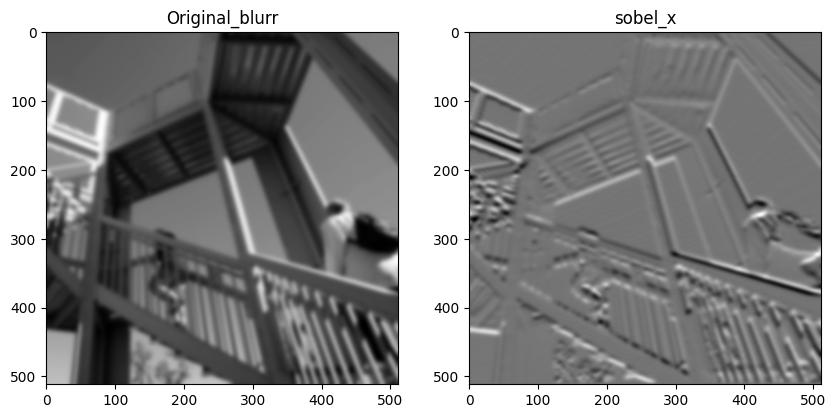

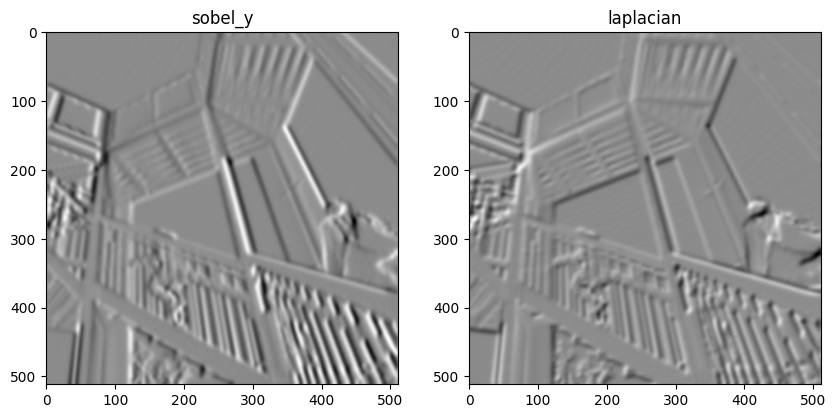

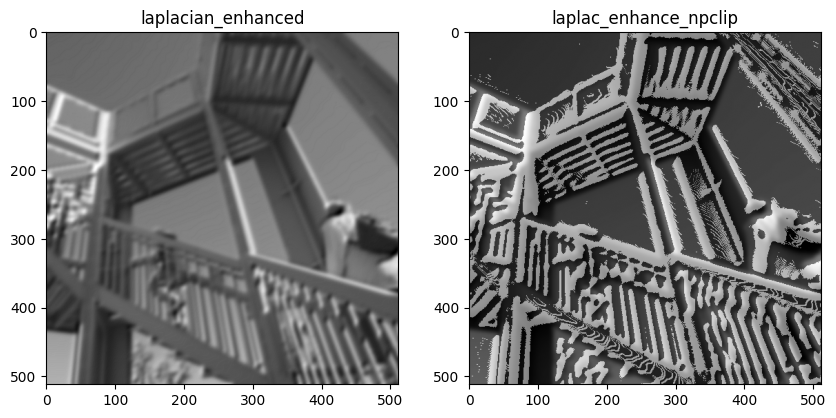

In [18]:
f = os.path.join(IMDIR, "/Users/jayotsana/Documents/sem_2_labs/image_processing/tp2/images/enhance/ascentB.png")

#Display properties
width=10
height=8

# Read and preprocess image
im = io.imread(f, as_gray=True)
im = im.astype(float)
# im = resize(im,(100,100))

# Display the original image
fig=plt.figure(figsize=(width, height))
plt.subplot(1,2,1)
plt.imshow(im, cmap = 'gray')
plt.title('Original_blurr')

# Convolve and display the filtered and the enhanced image
# np.clip(im,0,1)
sobel_im_x=ndimage.convolve(im,sobel_x())
plt.subplot(1,2,2)
plt.imshow(sobel_im_x, cmap = 'gray')
plt.title('sobel_x')

fig=plt.figure(figsize=(width, height))
sobel_im_y=ndimage.convolve(im,sobel_y())
plt.subplot(1,2,1)
plt.imshow(sobel_im_y, cmap = 'gray')
plt.title('sobel_y')

laplac_im=ndimage.convolve(im,laplacian())
plt.subplot(1,2,2)
plt.imshow(laplac_im, cmap = 'gray')
plt.title('laplacian')

fig=plt.figure(figsize=(width, height))
enhanceed_im=normalize(laplac_im)+normalize(im)
plt.subplot(1,2,1)  
plt.imshow(enhanceed_im, cmap = 'gray')
plt.title('laplacian_enhanced')

lap=np.clip(laplac_im,0,1)
enhanceed_im=normalize(lap)+normalize(im)
plt.subplot(1,2,2)  
plt.imshow(enhanceed_im, cmap = 'gray')
plt.title('laplac_enhance_npclip')

Text(0.5, 1.0, 'laplac_enhance_npclip')

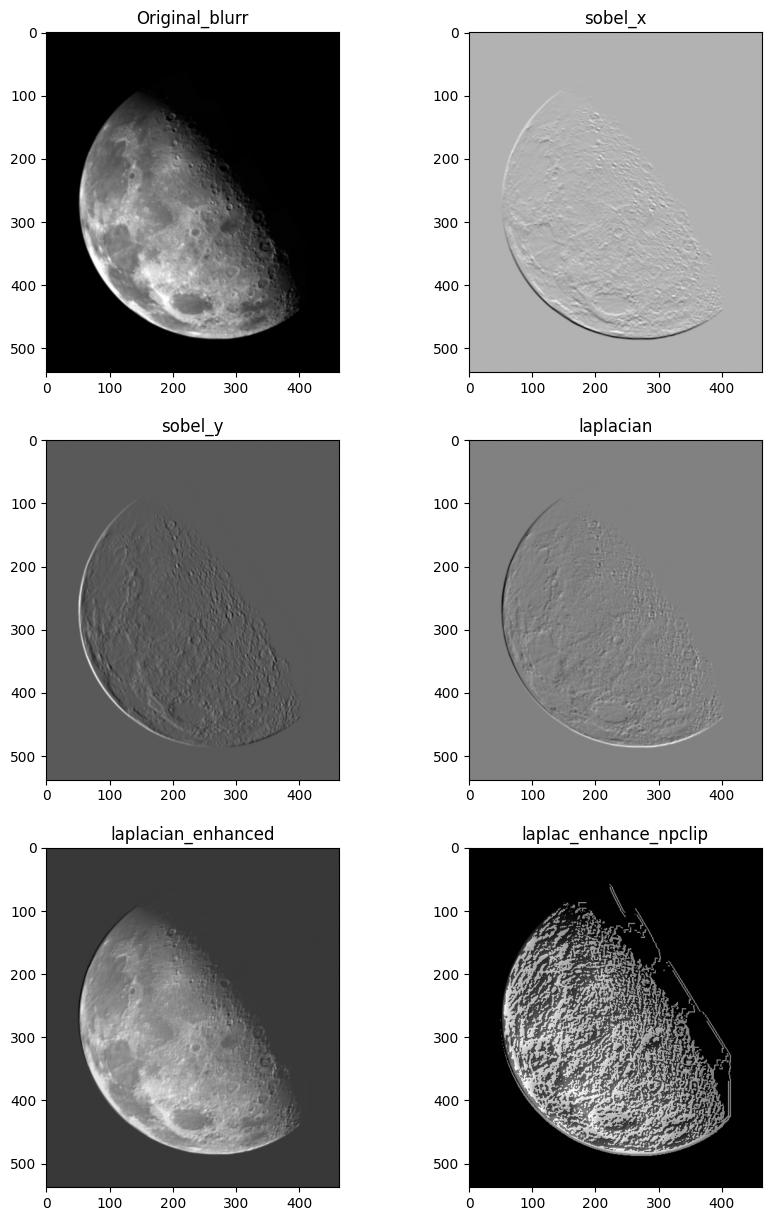

In [22]:
f = os.path.join(IMDIR, "/Users/jayotsana/Documents/sem_2_labs/image_processing/tp2/images/enhance/moon-blurred.tif")

#Display properties
width=10
height=15

# Read and preprocess image
im = io.imread(f, as_gray=True)
im = im.astype(float)
# im = resize(im,(100,100))

# Display the original image
fig1=plt.figure(figsize=(width, height))
plt.subplot(3,2,1)
plt.imshow(im, cmap = 'gray')
plt.title('Original_blurr')

# Convolve and display the filtered and the enhanced image
# np.clip(im,0,1)
sobel_im_x=ndimage.convolve(im,sobel_x())
plt.subplot(3,2,2)
plt.imshow(sobel_im_x, cmap = 'gray')
plt.title('sobel_x')

sobel_im_y=ndimage.convolve(im,sobel_y())
plt.subplot(3,2,3)
plt.imshow(sobel_im_y, cmap = 'gray')
plt.title('sobel_y')

laplac_im=ndimage.convolve(im,laplacian())
plt.subplot(3,2,4)
plt.imshow(laplac_im, cmap = 'gray')
plt.title('laplacian')

enhanceed_im=(normalize(laplac_im))+normalize(im)
plt.subplot(3,2,5)  
plt.imshow(enhanceed_im, cmap = 'gray')
plt.title('laplacian_enhanced')

lap=np.clip(laplac_im,0,1)
enhanceed_im=normalize(lap)+normalize(im)
plt.subplot(3,2,6)  
plt.imshow(enhanceed_im, cmap = 'gray')
plt.title('laplac_enhance_npclip')